# Loading

In [87]:
import sys
sys.path.insert(0, '../preprocess')

import pandas as pd
pd.set_option('display.max_columns', 100)

import importlib
import output_visualization as ov
#importlib.reload(ov)
import feature_engineering as fe
import model_helper_funcs as mhf
importlib.reload(mhf)

import shap
import eli5
import xgboost as xgb

%matplotlib inline
shap.initjs()

In [2]:
train_X, valid_X, train_y, valid_y = fe.get_data(
    '../data/train.csv', '../data/train_labels.csv')

memory used before preprocess:  19.00808

date time size before: 3.9798799999999996
date time size after:  0.47528 

converting funder                         size:  3.86	->	 0.33
converting installer                      size:  3.64	->	 0.34
converting basin                          size:  4.03	->	 0.06
converting subvillage                     size:  3.85	->	 2.03
converting region                         size:  3.78	->	 0.06
converting lga                            size:  3.83	->	 0.07
converting ward                           size:  3.83	->	 0.34
converting public_meeting                 size:  2.1	->	 0.06
converting recorded_by                    size:  4.75	->	 0.06
converting scheme_management              size:  3.55	->	 0.06
converting scheme_name                    size:  3.15	->	 0.4
converting permit                         size:  2.06	->	 0.06
converting extraction_type                size:  3.84	->	 0.06
converting extraction_type_group          size:  3.85	->	 0.06
con

In [3]:
train_X.head()

id  amount_tsh date_recorded funder  gps_height installer  \
3607     454        50.0    2013-02-27   Dmdd        2092      DMDD   
50870    510         0.0    2011-03-17   Cmsr           0      Gove   
20413  14146         0.0    2011-07-10   Kkkt           0      KKKT   
52806  47410         0.0    2011-04-12    NaN           0       NaN   
50091   1288       300.0    2011-04-05     Ki        1023        Ki   

       longitude  latitude                 wpt_name  num_private        basin  \
3607   35.426020 -4.227446                    Narmo            0     Internal   
50870  35.510074 -5.724555                   Lukali            0     Internal   
20413  32.499866 -9.081222                 Mahakama            0   Lake Rukwa   
52806  34.060484 -8.830208  Shule Ya Msingi Chosi A            0       Rufiji   
50091  37.032690 -6.040787                Kwa Mjowe            0  Wami / Ruvu   

         subvillage    region region_code district_code      lga      ward  \
3607   Bashnet Kati   Manyara          21             1   Babati  Bashinet   
50870        Lukali    Dodoma           1             6     Bahi   Lamaiti   
20413   Chawalikozi     Mbeya          12             6    Mbozi  Ndalambo   
52806       Shuleni     Mbeya          12             7  Mbarali   Chimala   
50091      Ngholong  Morogoro           5             1   Kilosa  Chakwale   

       population public_meeting              recorded_by scheme_management  \
3607          160           True  GeoData Consultants Ltd       Water Board   
50870           0           True  GeoData Consultants Ltd               VWC   
20413           0           True  GeoData Consultants Ltd               VWC   
52806           0           True  GeoData Consultants Ltd               VWC   
50091         120           True  GeoData Consultants Ltd               VWC   

      scheme_name permit  construction_year extraction_type  \
3607          NaN   True               1998         gravity   
50870         NaN   True                  0   india mark ii   
20413         NaN  False                  0           other   
52806         NaN   True                  0         gravity   
50091         NaN   True               1997           other   

      extraction_type_group extraction_type_class   management  \
3607                gravity               gravity  water board   
50870         india mark ii              handpump          vwc   
20413                 other                 other          vwc   
52806               gravity               gravity          vwc   
50091                 other                 other          vwc   

      management_group                payment payment_type water_quality  \
3607        user-group         pay per bucket   per bucket          soft   
50870       user-group              never pay    never pay          soft   
20413       user-group              never pay    never pay          soft   
52806       user-group            pay monthly      monthly          soft   
50091       user-group  pay when scheme fails   on failure         salty   

      quality_group      quantity quantity_group        source   source_type  \
3607           good  insufficient   insufficient        spring        spring   
50870          good        enough         enough  shallow well  shallow well   
20413          good        enough         enough  shallow well  shallow well   
52806          good  insufficient   insufficient         river    river/lake   
50091         salty        enough         enough  shallow well  shallow well   

      source_class     waterpoint_type waterpoint_type_group    status_group  
3607   groundwater  communal standpipe    communal standpipe      functional  
50870  groundwater           hand pump             hand pump      functional  
20413  groundwater               other                 other  non functional  
52806      surface  communal standpipe    communal standpipe  non functional  
50091  groundwater               other     

In [4]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 3607 to 56422
Data columns (total 41 columns):
id                       47520 non-null int32
amount_tsh               47520 non-null float64
date_recorded            47520 non-null datetime64[ns]
funder                   44644 non-null category
gps_height               47520 non-null int16
installer                44631 non-null category
longitude                47520 non-null float64
latitude                 47520 non-null float64
wpt_name                 47520 non-null object
num_private              47520 non-null int16
basin                    47520 non-null category
subvillage               47224 non-null category
region                   47520 non-null category
region_code              47520 non-null category
district_code            47520 non-null category
lga                      47520 non-null category
ward                     47520 non-null category
population               47520 non-null int16
public_meeting   

# Preprocess

## Train Preprocessing

In [5]:
trans = fe.DataCleaning()
transformed_train_X = trans.fit_transform(train_X)

In [7]:
train_y = transformed_train_X['status_group']
transformed_train_X.drop(['status_group'], axis=1, inplace=True)

In [14]:
col_names = transformed_train_X.columns

In [15]:
transformed_train_X.head()

amount_tsh  date_recorded funder  gps_height installer  longitude  \
3607     3.931826           3339   Dmdd        2092     OTHER  35.426020   
50870    0.000000           2626  OTHER           0      Gove  35.510074   
20413    0.000000           2741   Kkkt           0      KKKT  32.499866   
52806    0.000000           2652  OTHER           0     OTHER  34.060484   
50091    5.707110           2645     Ki        1023     OTHER  37.032690   

       latitude    region district_code  population public_meeting  \
3607  -4.227446   Manyara             1         160           True   
50870 -5.724555    Dodoma             6           0           True   
20413 -9.081222     Mbeya             6           0           True   
52806 -8.830208     Mbeya             7           0           True   
50091 -6.040787  Morogoro             1         120           True   

      scheme_management permit  construction_year extraction_type_class  \
3607        Water Board   True               38.0               gravity   
50870               VWC   True               40.0              handpump   
20413               VWC  False               40.0                 other   
52806               VWC   True               40.0               gravity   
50091               VWC   True               37.0                 other   

        management payment_type quality_group quantity_group        source  \
3607   water board   per bucket          good   insufficient        spring   
50870          vwc    never pay          good         enough  shallow well   
20413          vwc    never pay          good         enough  shallow well   
52806          vwc      monthly          good   insufficient         river   
50091          vwc   on failure         salty         enough  shallow well   

      waterpoint_type_group  
3607     communal standpipe  
50870             hand pump  
20413                 other  
52806    communal standpipe  
50091                 other

In [16]:
transformed_train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45517 entries, 3607 to 56422
Data columns (total 21 columns):
amount_tsh               45517 non-null float64
date_recorded            45517 non-null int64
funder                   45517 non-null category
gps_height               45517 non-null int16
installer                45517 non-null category
longitude                45517 non-null float64
latitude                 45517 non-null float64
region                   45517 non-null category
district_code            45517 non-null category
population               45517 non-null int16
public_meeting           45517 non-null category
scheme_management        45517 non-null category
permit                   45517 non-null category
construction_year        45517 non-null float64
extraction_type_class    45517 non-null category
management               45517 non-null category
payment_type             45517 non-null category
quality_group            45517 non-null category
quantity_group     

In [17]:
train_X_numeric, pipeline_ord = fe.transform_df(transformed_train_X, cat_encode_type="numeric")
train_X_1hot, pipeline_1hot = fe.transform_df(transformed_train_X, cat_encode_type="one hot")
train_X_numeric = pd.DataFrame(train_X_numeric, columns=col_names)
train_X_1hot.shape

(45517, 257)

In [18]:
y_encoder_num, train_y_num = fe.encode_labels(train_y, convert_type="numeric")
#y_encoder_1hot, train_y_1hot = fe.encode_labels(train_y, convert_type="one hot")

## Validation Preprocessing

In [19]:
transformed_valid_X = trans.transform(valid_X)
valid_y = transformed_valid_X['status_group']
transformed_valid_X.drop(['status_group'], axis=1, inplace=True)

In [20]:
#valid_X_numeric = fe.transform_df(transformed_valid_X, cat_encode_type="numeric")
# y_encoder_num
valid_X_numeric = pipeline_ord.transform (transformed_valid_X)
valid_X_1hot = pipeline_1hot.transform(transformed_valid_X)
valid_X_numeric = pipeline_ord.transform(transformed_valid_X)
valid_X_numeric = pd.DataFrame(data=valid_X_numeric, columns=col_names, )
valid_X_1hot.shape

(11367, 257)

In [21]:
#valid_X_numeric#.values

In [22]:
valid_y_num = y_encoder_num.transform(valid_y)
#valid_y_1hot = y_encoder_1hot.transform(valid_y)

# Models

## XBG

In [23]:
%%time

xgc = xgb.XGBClassifier(
    n_estimators=50,
    max_depth=5,
    base_score=0.5,
    objective='multi:softprob', 
    random_state=42
)
xgc.fit(train_X_numeric, train_y_num)
print (xgc)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
CPU times: user 15.4 s, sys: 129 ms, total: 15.5 s
Wall time: 16 s


### Visualization

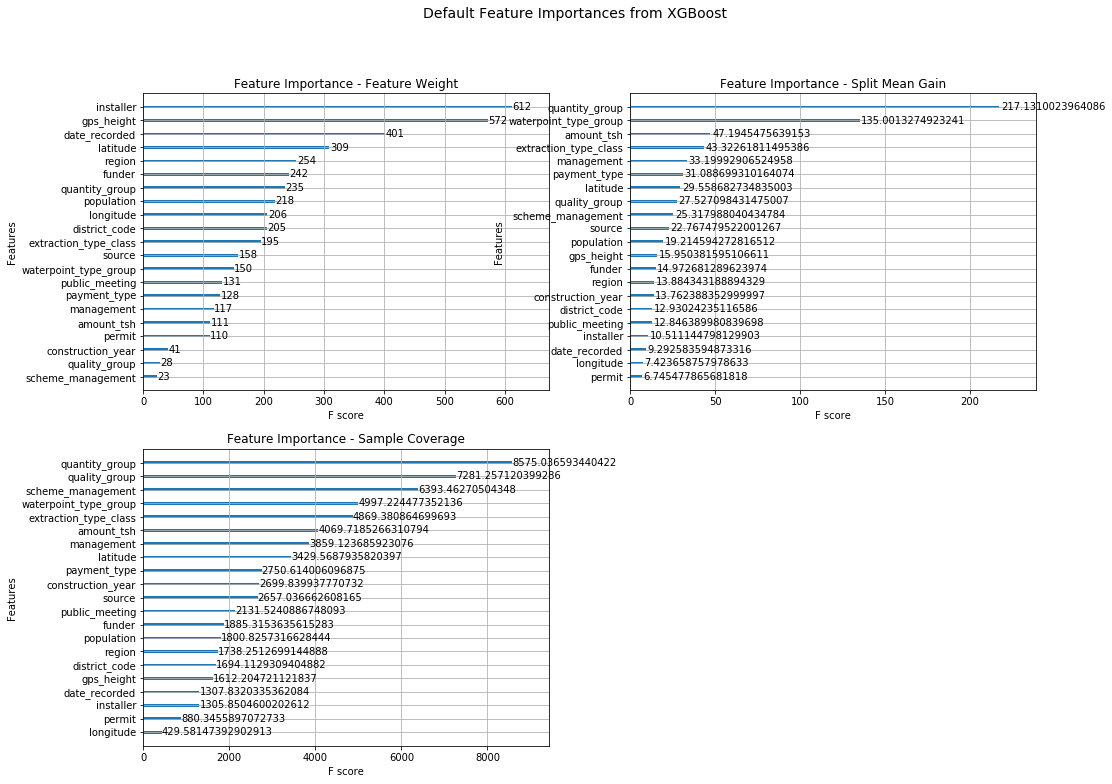

In [24]:
ov.xgb_feature_importance(xgc)

In [25]:
# show how influential each feature is to the final prediction
eli5.show_weights(xgc.get_booster())

In [26]:
y_pred = xgc.predict(valid_X_numeric)

In [27]:
doc_num_0 = ov.eli_instance(valid_y_num, y_pred, label_value=0, match=True)
doc_num_1 = ov.eli_instance(valid_y_num, y_pred, label_value=1, match=True)
doc_num_2 = ov.eli_instance(valid_y_num, y_pred, label_value=2, match=True)

Actual Label: 0
Predicted Label: 0
Actual Label: 1
Predicted Label: 1
Actual Label: 2
Predicted Label: 2


In [28]:
eli5.show_prediction(
    xgc.get_booster(), 
    valid_X_numeric.iloc[doc_num_0],
    feature_names=list (col_names),
    show_feature_values=True
)

In [29]:
eli5.show_prediction(
    xgc.get_booster(), 
    valid_X_numeric.iloc[doc_num_1],
    feature_names=list(transformed_valid_X.columns),
    show_feature_values=True
)

In [30]:
eli5.show_prediction(
    xgc.get_booster(), 
    valid_X_numeric.iloc[doc_num_2],
    feature_names=list(transformed_valid_X.columns),
    show_feature_values=True
)

In [31]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

"""
the more a model’s decision criteria depend on a feature,
the more we’ll see predictions change as a function of perturbing a feature
"""

interpreter = Interpretation(
    training_data=valid_X_numeric,
    training_labels=valid_y_num,
    feature_names=list(transformed_valid_X.columns)
)

im_model = InMemoryModel(
    xgc.predict_proba,
    examples=train_X_numeric,
    target_names=['0', '1', '2']
)

2019-01-12 15:06:53,497 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[21/21] features ████████████████████ Time elapsed: 15 seconds

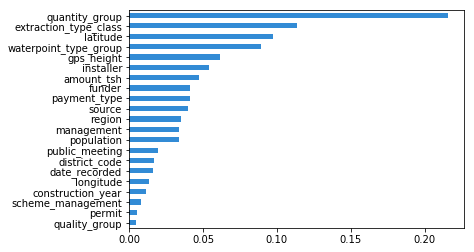

In [32]:
plots = interpreter.feature_importance.plot_feature_importance(
    im_model,
    ascending=True,
    n_samples=23000,
)

2019-01-12 15:07:26,429 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[28/28] grid cells ████████████████████ Time elapsed: 11 seconds

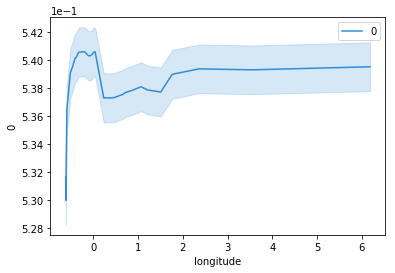

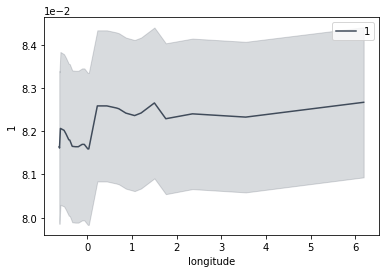

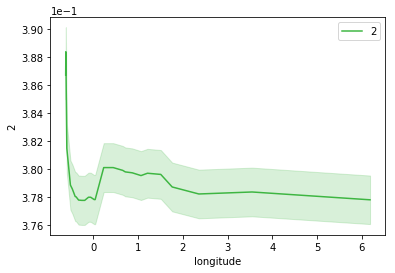

In [33]:
"""
Describes the marginal impact of a feature on model prediction,
assuming all other features are constant.
"""

"""
the axis is awkward since I used standard scaler
I guess the axis should just be ignored
"""
r = interpreter.partial_dependence.plot_partial_dependence(
    #[('longitude', 'latitude')],
    ['longitude'],
    im_model,
    grid_resolution=50,
    grid_range=(0, 1),
    n_samples=23000,
    with_variance=True,
    figsize=(6, 4)
)

2019-01-12 15:07:52,635 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[5/5] grid cells ████████████████████ Time elapsed: 2 seconds

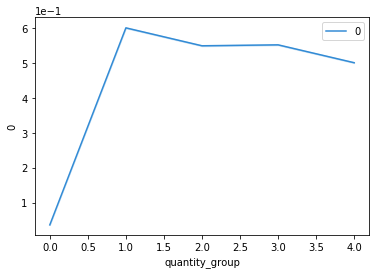

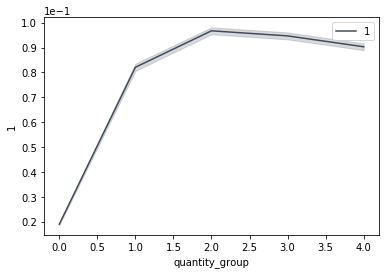

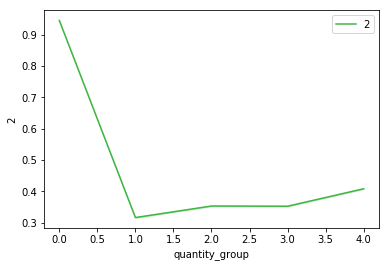

In [34]:
# note that in this case, the column is categorical, so a line plot doesn't entirely make sense
r = interpreter.partial_dependence.plot_partial_dependence(
    ['quantity_group'],
    im_model,
    grid_resolution=50,
    grid_range=(0, 1),
    n_samples=23000,
    with_variance=True,
    figsize=(6, 4)
)

In [35]:
xgc_np = xgb.XGBClassifier(n_estimators=5, max_depth=5, base_score=0.5,
                           objective='multi:softprob', random_state=42)
xgc_np.fit(train_X_numeric.values, train_y_num)

from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

exp = LimeTabularExplainer(
    valid_X_numeric.values,
    feature_names=col_names,
    discretize_continuous=True,
    class_names=['0', '1', '2']
)

In [36]:
exp.explain_instance(
    valid_X_numeric.iloc[doc_num_0],
    xgc_np.predict_proba
).show_in_notebook()

In [37]:
exp.explain_instance(
    valid_X_numeric.iloc[doc_num_1],
    xgc_np.predict_proba
).show_in_notebook()

In [38]:
exp.explain_instance(
    valid_X_numeric.iloc[doc_num_2], 
    xgc_np.predict_proba
).show_in_notebook()

In [39]:
import shap
explainer = shap.TreeExplainer(xgc)
shap_values = explainer.shap_values(valid_X_numeric)
print('Expected Value:', explainer.expected_value)

Expected Value: [1.1007421, -0.7670301, 0.7320869]


In [40]:
# need to run this 
#!jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10
# shap.force_plot(
#     explainer.expected_value[0],
#     shap_values[0],
#     np_valid_X.iloc[2,:].values
# )

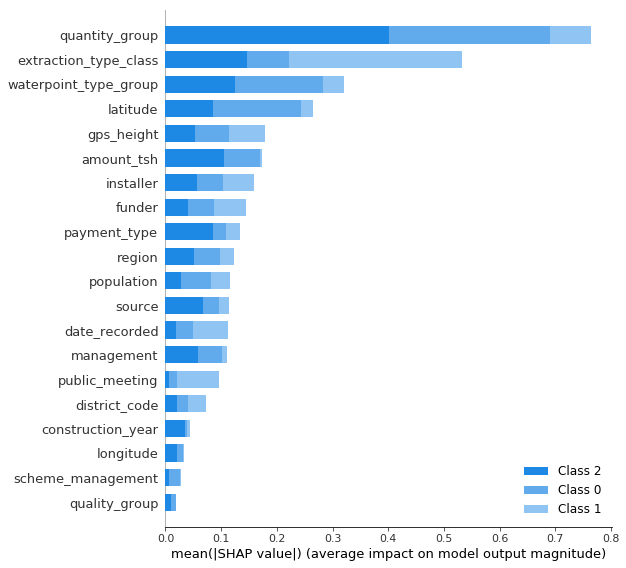

In [41]:
shap.summary_plot(shap_values, 
                  valid_X_numeric, plot_type="bar")

### Measuring Success

In [42]:
ov.test_measure(valid_y_num, y_pred, metric="accuracy")

Accuracy: 74.58%


## SGD

In [94]:
#alpha: parameter to tune for l2
#eta0: Learning rate
sgd_param_grid = {
    'alpha': [0.00030, 0.0004, 0.0005],
    'eta0': [0.0001, 0.0005, 0.001]
}

In [97]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(
    random_state=42,
    learning_rate='optimal',
    penalty='l2'
)

%time
sgd_clf_rand = mhf.rand_search(
    sgd_clf,
    sgd_param_grid,
    train_X_1hot,
    train_y_num
)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs
Best parameters:
 {'eta0': 0.0001, 'alpha': 0.0004}
Cross Validation scores:
 [0.73868055 0.74143158 0.73872924]


In [98]:
mhf.valid_score(sgd_clf_rand, valid_X_1hot, valid_y_num)

Validation Set Scores:
 [0.72216359 0.68989179 0.6438754 ]


In [111]:
from sklearn.model_selection import cross_val_predict
# sgd_clf_pred = cross_val_predict(
#     sgd_clf, 
#     valid_X_1hot, 
#     valid_y_num
# )
sgd_clf_pred = sgd_clf_rand.predict(valid_X_1hot)

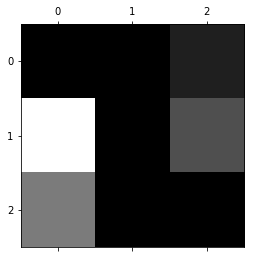

In [110]:
ov.conf_mx_rates(valid_y_num, sgd_clf_pred)

In [121]:
from sklearn.metrics import classification_report
target_names = list (y_encoder_num.classes_)
print (classification_report(
    valid_y_num, 
    sgd_clf_pred,
    target_names=target_names
))

                         precision    recall  f1-score   support

             functional       0.72      0.90      0.80      6175
functional needs repair       0.38      0.02      0.04       782
         non functional       0.79      0.64      0.70      4410

              micro avg       0.74      0.74      0.74     11367
              macro avg       0.63      0.52      0.51     11367
           weighted avg       0.72      0.74      0.71     11367



## Softmax Logistic

In [124]:
from sklearn.linear_model import LogisticRegression

softmax_param_grid = {
    'C': [.5, 1, 2], #higher this is, the less the model is regularized
}

softmax_reg = LogisticRegression(
    multi_class="multinomial", 
    solver="lbfgs",
    penalty='l2',
)

softmax_reg_rand = mhf.rand_search(
    softmax_reg,
    softmax_param_grid,
    train_X_1hot,
    train_y_num
)

Best parameters:
 {'C': 1}
Cross Validation scores:
 [0.74441442 0.74841814 0.74709992]


In [103]:
mhf.valid_score(softmax_reg_rand, valid_X_1hot, valid_y_num)

Validation Set Scores:
 [0.74722955 0.74267617 0.73231257]


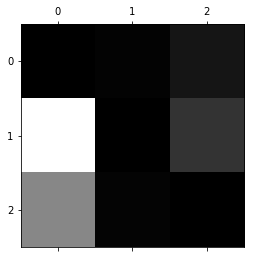

In [116]:
softmax_reg_pred = softmax_reg_rand.predict(valid_X_1hot)
ov.conf_mx_rates(valid_y_num, softmax_reg_pred)

In [123]:
print (classification_report(
    valid_y_num, 
    softmax_reg_pred, 
    target_names=target_names
))

                         precision    recall  f1-score   support

             functional       0.71      0.93      0.80      6175
functional needs repair       0.39      0.09      0.15       782
         non functional       0.84      0.59      0.69      4410

              micro avg       0.74      0.74      0.74     11367
              macro avg       0.64      0.54      0.55     11367
           weighted avg       0.74      0.74      0.71     11367



## Linear SVC

In [128]:
from sklearn.svm import LinearSVC

svc_clf = LinearSVC(loss="hinge")
svc_param_grid = {
    'C': [.5, 1, 2],
}

svc_clf_rand = mhf.rand_search(
    svc_clf,
    svc_param_grid,
    train_X_1hot,
    train_y_num
)

Best parameters:
 {'C': 0.5}
Cross Validation scores:
 [0.72385158 0.74050883 0.73602689]


In [129]:
mhf.valid_score(svc_clf_rand, valid_X_1hot, valid_y_num)

Validation Set Scores:
 [0.73799472 0.74505146 0.72756072]


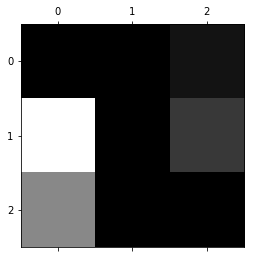

In [130]:
svc_clf_pred = svc_clf_rand.predict(valid_X_1hot)
ov.conf_mx_rates(valid_y_num, svc_clf_pred)

In [131]:
print (classification_report(
    valid_y_num, 
    svc_clf_pred, 
    target_names=target_names
))

                         precision    recall  f1-score   support

             functional       0.69      0.94      0.80      6175
functional needs repair       1.00      0.00      0.01       782
         non functional       0.83      0.57      0.67      4410

              micro avg       0.73      0.73      0.73     11367
              macro avg       0.84      0.50      0.49     11367
           weighted avg       0.77      0.73      0.69     11367



## Decision Trees

In [136]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier()

tree_param_grid = {
    'max_depth': [20, 25, 30],
    'min_samples_leaf': [35, 40, 45],
    'max_leaf_nodes': [35, 40, 45],
    'max_features': [30, 35, 40]
}

tree_clf_rand = mhf.rand_search(
    tree_clf,
    tree_param_grid,
    train_X_1hot,
    train_y_num
)

Best parameters:
 {'min_samples_leaf': 45, 'max_leaf_nodes': 40, 'max_features': 35, 'max_depth': 25}
Cross Validation scores:
 [0.7099453  0.72778803 0.70880569]


In [137]:
mhf.valid_score(tree_clf_rand, valid_X_1hot, valid_y_num)

Validation Set Scores:
 [0.68153034 0.70704671 0.68717001]


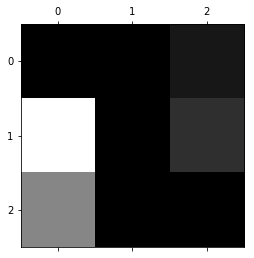

In [138]:
tree_clf_pred = tree_clf_rand.predict(valid_X_1hot)
ov.conf_mx_rates(valid_y_num, tree_clf_pred)

In [139]:
print (classification_report(
    valid_y_num, 
    tree_clf_pred, 
    target_names=target_names
))

                         precision    recall  f1-score   support

             functional       0.69      0.92      0.79      6175
functional needs repair       0.00      0.00      0.00       782
         non functional       0.80      0.56      0.66      4410

              micro avg       0.72      0.72      0.72     11367
              macro avg       0.50      0.49      0.48     11367
           weighted avg       0.68      0.72      0.68     11367



In [145]:
# creates a graph, but this introduces unneccesary complications
# from sklearn.tree import export_graphviz

# export_graphviz(
#     tree_clf,
#     out_file="graphs/modelv1_decision_tree.dot",
#     feature_names=col_names,
#     class_names=target_names,
#     rounded=True,
#     filled=True
# )

## Random Forests

In [148]:
from sklearn.ensemble import RandomForestClassifier
rand_forest_clf = RandomForestClassifier()
rand_forest_param_grid = {
    'max_depth': [35, 40, 45],
    'min_samples_leaf': [30, 35, 40],
    'max_leaf_nodes': [65, 70, 75],
    'max_features': [20, 25, 30]
}

rand_forest_clf_rand = mhf.rand_search(
    rand_forest_clf,
    rand_forest_param_grid,
    train_X_1hot,
    train_y_num
)

Best parameters:
 {'min_samples_leaf': 35, 'max_leaf_nodes': 75, 'max_features': 30, 'max_depth': 35}
Cross Validation scores:
 [0.74171225 0.74419984 0.743343  ]


In [150]:
mhf.valid_score(rand_forest_clf_rand, valid_X_1hot, valid_y_num)

Validation Set Scores:
 [0.7353562  0.73370282 0.72650475]


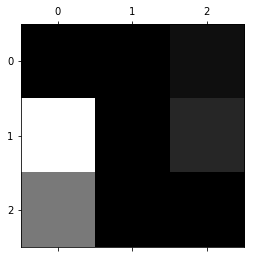

In [151]:
rand_forest_clf_pred = rand_forest_clf_rand.predict(valid_X_1hot)
ov.conf_mx_rates(valid_y_num, rand_forest_clf_pred)

In [161]:
print (classification_report(
    valid_y_num, 
    rand_forest_clf_pred, 
    target_names=target_names
))

                         precision    recall  f1-score   support

             functional       0.70      0.95      0.81      6175
functional needs repair       0.60      0.01      0.02       782
         non functional       0.86      0.59      0.70      4410

              micro avg       0.74      0.74      0.74     11367
              macro avg       0.72      0.52      0.51     11367
           weighted avg       0.76      0.74      0.71     11367



## AdaBoost

In [158]:
from sklearn.ensemble import AdaBoostClassifier

%time
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    algorithm="SAMME.R",
)

ada_param_grid = {
    'learning_rate':[1.0]
}

ada_clf_rand = mhf.rand_search(
    ada_clf,
    ada_param_grid,
    train_X_1hot,
    train_y_num
)

CPU times: user 4 µs, sys: 14 µs, total: 18 µs
Wall time: 67.7 µs
Best parameters:
 {'learning_rate': 1.0}
Cross Validation scores:
 [0.7280696  0.73464276 0.73049038]


In [159]:
mhf.valid_score(ada_clf_rand, valid_X_1hot, valid_y_num)

Validation Set Scores:
 [0.72453826 0.72631301 0.71752904]


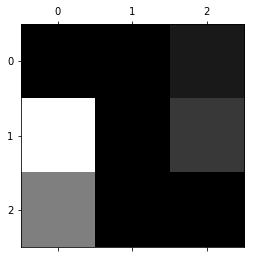

In [160]:
ada_clf_pred = ada_clf_rand.predict(valid_X_1hot)
ov.conf_mx_rates(valid_y_num, ada_clf_pred)

In [163]:
print (classification_report(
    valid_y_num, 
    ada_clf_pred, 
    target_names=target_names
))

                         precision    recall  f1-score   support

             functional       0.70      0.92      0.79      6175
functional needs repair       0.35      0.01      0.02       782
         non functional       0.80      0.59      0.68      4410

              micro avg       0.73      0.73      0.73     11367
              macro avg       0.62      0.51      0.50     11367
           weighted avg       0.72      0.73      0.70     11367



In [166]:
"""
Check out:

https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
"""
print('')